cn_data
  chr  bin    cell_id  state  start  end cluster_id      copy
0   1    0  cl1_cell0      3      0    9        cl1  3.778983
1   1    1  cl1_cell0      6     10   19        cl1  6.398886
2   1    2  cl1_cell0      3     20   29        cl1  3.479009
3   1    3  cl1_cell0      3     30   39        cl1  3.435461
4   1    4  cl1_cell0      2     40   49        cl1  2.475882


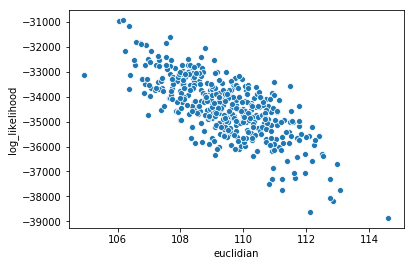

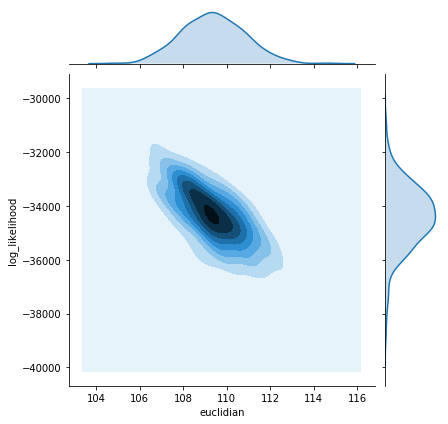

In [3]:
from scgenome import utils
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import numpy as np
from scgenome.jointcnmodels import get_variances, get_tr_probs, calculate_marginal_ll_simple
from scipy import special
import seaborn as sns
import pandas as pd

n_cell = 30
n_bin = 3000

cn_mat = np.concatenate([1+np.random.poisson(lam=2, size=n_bin)[np.newaxis,:] for i in range(n_cell)])
n_states = cn_mat.max()
cell_ids = [f"cl1_cell{i}" for i in range(n_cell)]
chr_names = ["1", "2"]
df_cn_mat = utils.cn_mat_as_df(cn_mat, chr_names)
#print(f"df_cn_mat \n {df_cn_mat}")

cn_data = utils.cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_", expand=True).iloc[:, 0]
cn_data["state"] = cn_data["copy"] + abs(np.random.normal(scale=0.5,size=cn_data.shape[0]))
cn_data.columns = ["chr","bin","cell_id","state","start","end","cluster_id","copy"]

#matrix_data, measurement, cell_ids = utils.cn_data_to_mat_data_ids(cn_data, value_ids=["copy"])
#matrix_data2 = (
#    cn_data
#        .merge(pd.DataFrame({'cell_id': cell_ids}))
#        .set_index(['chr', 'start', 'cell_id'])[['state', 'copy']]
#        .unstack(level=2, fill_value=0.))

print("cn_data")
print(cn_data.head())
#variances = get_variances(cn_data, matrix_data, n_state)
cell_state_var = cn_data[['cell_id', 'state', 'copy']].dropna() \
                    .groupby(['cell_id', 'state'])['copy'] \
                    .var().rename('copy_var') \
                    .reset_index()
#print("cell_state_var")
#print(cell_state_var)
    
variances = cell_state_var.set_index(["state",'cell_id'])['copy_var'].unstack()
#print(variances.head())
#print(variances.shape)
variances = variances.reindex(columns=cell_ids, index=range(n_states)).fillna(0.05).T
variances = variances.values

variances[variances < 0.001] = 0.001

my_variances = get
#variances = get_variances(cn_data, matrix_data, n_state)

trans_model = {"kind":"twoparam", "e0": 0.9, "e1": 0.1}

pw_euc = squareform(pdist(cn_mat))

pw_ll = np.zeros((n_cell, n_cell))
for i,j in combinations(range(n_cell), 2):
    pw_ll[i, j] = calculate_marginal_ll_simple(cn_mat[[i,j], :], variances[[i,j], :], trans_model)
    
#print(f"pw_euc \n{pw_euc}")
#print(f"pw_ll \n{pw_ll}")
#print(f"cn_mat \n{cn_mat}")
#print(f"cn_data \n{cn_data}")

pwd = pd.DataFrame({"euclidian" : pw_euc[np.triu_indices(n_cell,1)],
                    "log_likelihood" : pw_ll[np.triu_indices(n_cell,1)]})
sns.scatterplot(data=pwd, x="euclidian", y="log_likelihood")
sns.jointplot(data=pwd, x="euclidian", y="log_likelihood", kind="kde")

In [17]:
sum((cn_mat[0,:] - cn_mat[1,:])**2)**0.5

30.988042892548794

In [12]:
pw_euc

array([[ 0.        , 30.98804289, 31.82838566, ..., 32.03855084,
        32.40225677, 32.90686509],
       [30.98804289,  0.        , 31.56414923, ..., 31.2849748 ,
        30.41000579, 31.282114  ],
       [31.82838566, 31.56414923,  0.        , ..., 31.31081775,
        30.54465633, 33.10146208],
       ...,
       [32.03855084, 31.2849748 , 31.31081775, ...,  0.        ,
        32.18035399, 32.74232728],
       [32.40225677, 30.41000579, 30.54465633, ..., 32.18035399,
         0.        , 31.68167703],
       [32.90686509, 31.282114  , 33.10146208, ..., 32.74232728,
        31.68167703,  0.        ]])